In [3]:
import numpy as np
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

### Wave Generation

A sine wave is a smooth, repetitive oscillation depicted as
$$ y = A \sin(\omega t + \phi) $$

It represents a periodic function with a constant amplitude $A$, frequency $ f = \frac{\omega}{2\pi} $, angular frequency $ \omega $, time $t$, and phase angle $\phi$. This wave form is fundamental in describing periodic phenomena like sound and light.

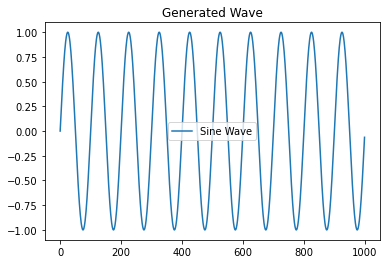

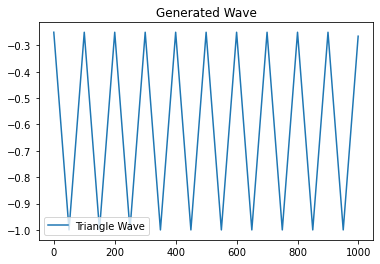

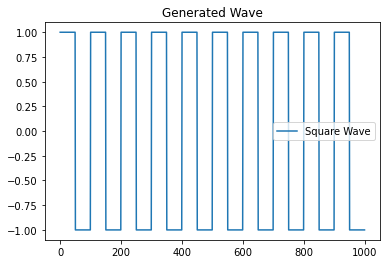

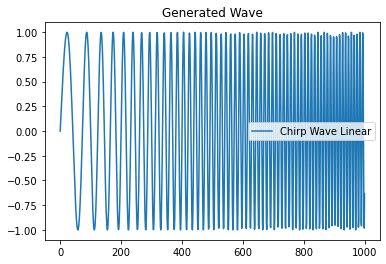

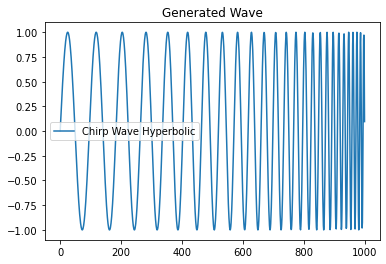

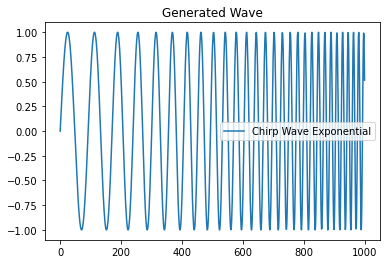

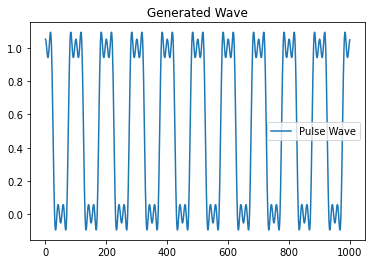

In [4]:
from dsp import sine_wave, triangle_wave, square_wave, chirp_wave_linear, chirp_wave_hyperbolic, chirp_wave_exponential, pulse_wave

sine_ = sine_wave(show=True)
triangle_ = triangle_wave(show=True)
square_ = square_wave(show=True)
chirp_linear_ = chirp_wave_linear(show=True)
chirp_hyperbolic_ = chirp_wave_hyperbolic(show=True)
chirp_exponential_ = chirp_wave_exponential(show=True)
pulse_ = pulse_wave(show=True)

### Add Noise

 **White Noise:** White noise $ W(t) $ has constant power spectral density: $ S_W(f) = \text{constant} $

 **Band-Limited White Noise:** Band-limited white noise $ B(t) $ is confined to a frequency range $[f_1, f_2]$: $ S_B(f) = \begin{cases} \text{constant}, & \text{if } f_1 \leq |f| \leq f_2 \\ 0, & \text{otherwise} \end{cases} $

 **Impulsive Noise:** Impulsive noise $ I(t) $ is characterized by Dirac delta functions: $ I(t) = \sum_{n} A_n \delta(t - t_n) $

**Burst Noise:**  Burst noise $ B(t) $ is modeled as a sum of pulses: $ B(t) = \sum_{n} A_n \text{sinc}(\omega t - \phi_n) $

**Brown Noise:** Brown noise $ X(t)$ is integrated white noise: $ X(t) = \int_{0}^{t} W(\tau) d\tau $

**Pink Noise:** Pink noise $ P(t) $ has a power spectral density inversely proportional to frequency: $ S_P(f) = \frac{\text{constant}}{f} $

**Flicker Noise:** Flicker noise $ F(t) $ exhibits a power spectral density proportional to $ \frac{1}{f} $: $ S_F(f) \propto \frac{1}{f} $

**Powerline Noise:** Powerline noise $ P(t) $ interferes with signals, often sinusoidal: $ P(t) = A \sin(2\pi f_{\text{power}} t) $

**Resonance Noise:** Resonance noise $ R(t) $ arises from resonant frequencies: $ R(t) = \sum_{n} A_n \sin(\omega_n t + \phi_n) $

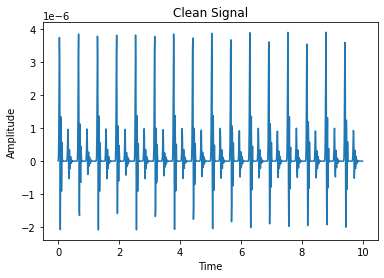

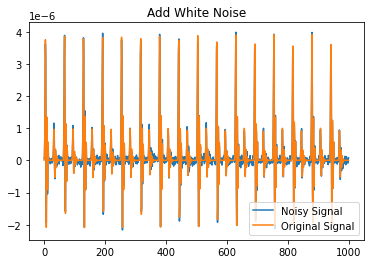

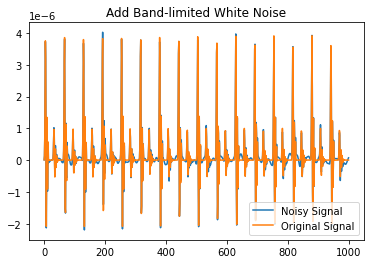

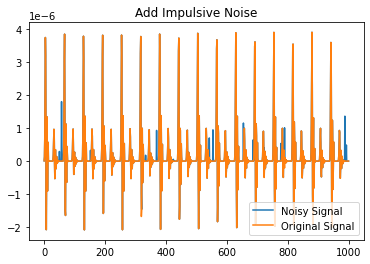

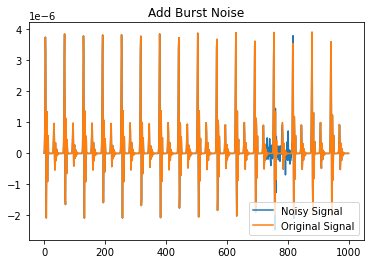

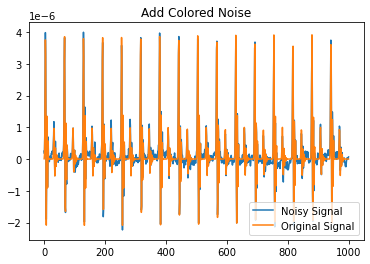

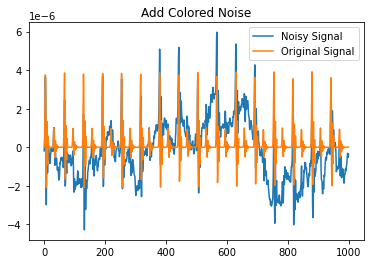

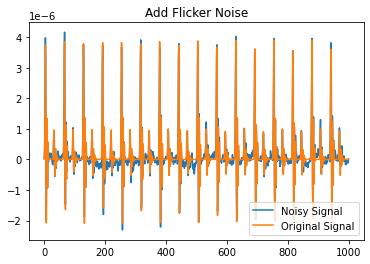

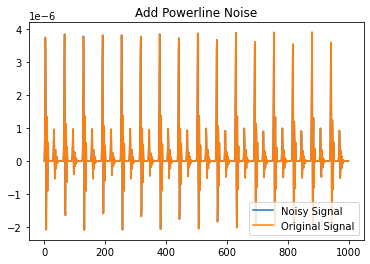

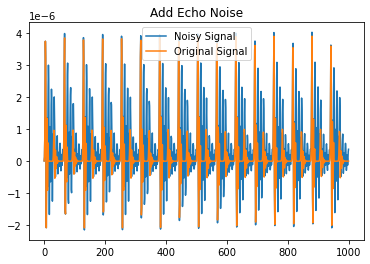

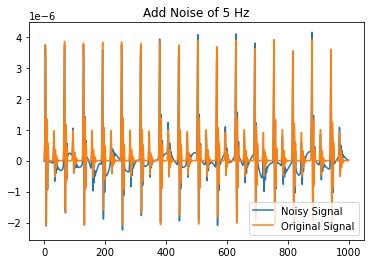

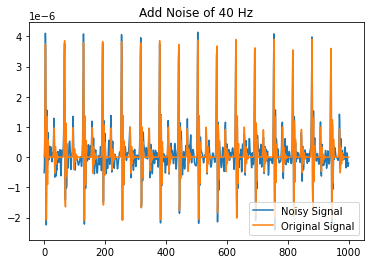

In [5]:
from dsp import add_white_noise, add_band_limited_white_noise, add_impulsive_noise, add_burst_noise, add_colored_noise, add_distort_noise
from dsp import add_flicker_noise, add_thermal_noise, add_powerline_noise, add_echo_noise
from Dataset import load_scg

signals_clean, labels_clean, duration, fs = load_scg(0, 'train')
signal = signals_clean[0]
sampling_rate = fs

time = np.linspace(0, duration, sampling_rate * duration, endpoint=False)

plt.plot(time, signal)
plt.ylabel('Amplitude')
plt.xlabel('Time')
plt.title('Clean Signal')

signal_with_white_noise = add_white_noise(signal, show=True)
signal_with_band_limited_white_noise = add_band_limited_white_noise(signal, noise_amplitude=0.3, show=True)
signal_with_impulsive_noise = add_impulsive_noise(signal, noise_amplitude=1, number=25, show=True)
signal_with_burst_noise = add_burst_noise(signal, noise_amplitude=0.3, show=True)
signal_with_pink_noise = add_colored_noise(signal, model=0, show=True)
signal_with_brown_noise = add_colored_noise(signal, model=1, show=True)
signal_with_flicker_noise = add_flicker_noise(signal, show=True)
# signal_with_thermal_noise = add_thermal_noise(signal, show=True)
signal_with_power_line = add_powerline_noise(signal, show=True)


attenuation_factor = [0.8, 0.6, 0.4]
delay_factor = [10, 20, 30]
noisy_signal = add_echo_noise(signal, 3, attenuation_factor, delay_factor, show=True)

signal_with_lowfreq_noise = add_distort_noise(signal, n_samples=1000,sampling_rate=100, noise_frequency=5, noise_amplitude=0.3, show=True )

signal_with_lowfreq_noise = add_distort_noise(signal, n_samples=1000,sampling_rate=100, noise_frequency=40, noise_amplitude=0.3, show=True )

### Decompose


###### 1. **Seasonal Decomposition:**
   Seasonal decomposition is a time series analysis method that separates a time series into its trend, seasonal, and residual components. The model can be expressed as $y(t) = T(t) + S(t) + R(t)$, where $T(t)$ is the trend, $S(t)$ is the seasonal component, and $R(t)$ is the residual.


###### 2. **Empirical Mode Decomposition (EMD):**
   EMD decomposes a signal into intrinsic mode functions (IMFs) based on local extrema. Each IMF represents a specific oscillatory mode. Mathematically, a signal $x(t)$ is decomposed as $x(t) = \sum_{i=1}^{n} C_i(t) + R(t)$, where $C_i(t)$ is the $i$-th IMF and $R(t)$ is the residual.


###### 3. **Ensemble Empirical Mode Decomposition (EEMD):**
   EEMD is an extension of EMD that addresses mode mixing by adding noise and performing multiple decompositions. It aims to improve the decomposition results by providing a more stable representation of the signal's components.


###### 4. **Complete Ensemble Empirical Mode Decomposition (CEEMD):**
   CEEMD is a further enhancement of EEMD that uses an ensemble of EMD decompositions with different white noise added at each iteration. It improves upon EEMD by reducing the residual error and enhancing the decomposition's accuracy.


###### 5. **Variational Mode Decomposition (VMD):**
   VMD decomposes a signal into a set of oscillatory modes with varying frequencies. It minimizes the mode mixing problem by solving a variational optimization problem. The decomposition can be expressed as $x(t) = \sum_{i=1}^{n} u_i(t) + R(t)$, where $u_i(t)$ are the modes and $R(t)$ is the residual.

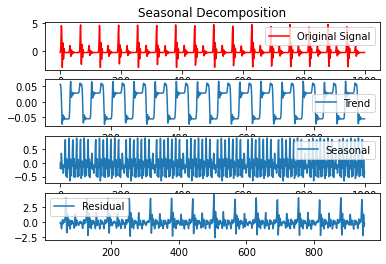

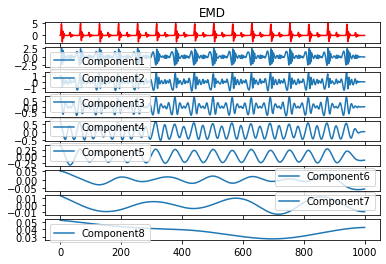

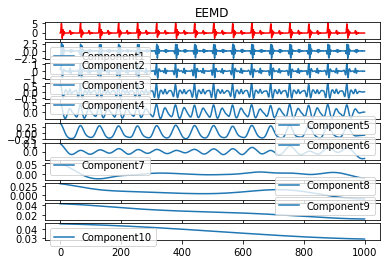

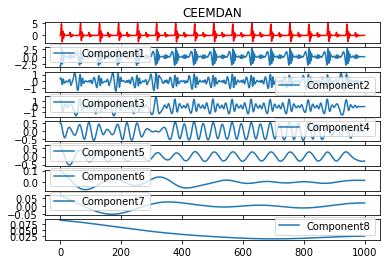

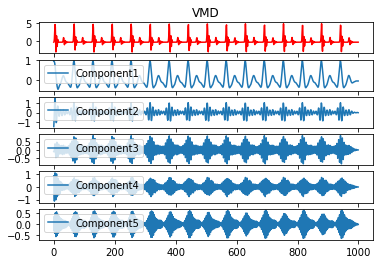

In [4]:
from dsp import seasonal_decomposition, emd_decomposition, eemd_decomposition,ceemd_decomposition, vmd_decomposition

_ = seasonal_decomposition(signal, show=True)
_ = emd_decomposition(signal, show=True)
_ = eemd_decomposition(signal, show=True)
_ = ceemd_decomposition(signal, show=True)
_ = vmd_decomposition(signal, show=True)
# serial_emd_decomposition(signals[:5, :], num_interval=5)

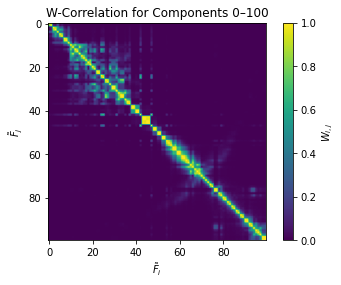

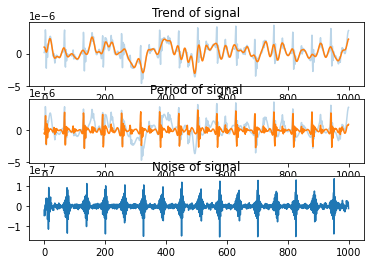

In [6]:
# Source code of SSA from https://www.kaggle.com/jdarcy/introducing-ssa-for-time-series-decomposition
# you can also check this link for details

from dsp import SSA
# Load SCG data with specified parameters
signals, labels, duration, fs = load_scg(0.8, 'train')

# Choose a specific signal from the loaded dataset
idx = 0
signal = signals[idx]

# Apply Singular Spectrum Analysis (SSA) to the selected signal
ssa_signal = SSA(signal, 100)

# Calculate and store the within-correlation matrix
ssa_signal.calc_wcorr()
Wcorr_matrix = ssa_signal.Wcorr

# Plot the within-correlation matrix
ssa_signal.plot_wcorr()
plt.title(r"W-Correlation for Components 0–100")
plt.show()

# Create subplots to visualize different components of the signal
plt.subplots(3, 1)

# Plot the original signal and its trend component
plt.subplot(3, 1, 1)
ssa_signal.orig_TS.plot(alpha=0.3)  # Plot original signal with transparency
ssa_signal.reconstruct(slice(0, 10)).plot()  # Plot reconstructed trend component
plt.title("Trend of signal")

# Plot the original signal and its periodic component
plt.subplot(3, 1, 2)
ssa_signal.orig_TS.plot(alpha=0.3)
ssa_signal.reconstruct(slice(11, 46)).plot()  # Plot reconstructed periodic component
plt.title("Period of signal")

# Plot the original signal and its noise component
plt.subplot(3, 1, 3)
# ssa_signal.orig_TS.plot(alpha=0.3)
ssa_signal.reconstruct(slice(46, 100)).plot()  # Plot reconstructed noise component
plt.title("Noise of signal")

# Display the plots
plt.show()


###### Blind Source Separation
BSS is a signal processing technique that aims to extract independent source signals from their observed mixtures. Two widely used methods for BSS are Principal Component Analysis (PCA) and Independent Component Analysis (ICA).


###### PCA-Based Blind Source Separation
PCA is employed to transform the observed mixed signals into a new set of uncorrelated variables called principal components. In the context of BSS, PCA can be applied to the covariance matrix of the observed signals. The principal components are ordered in terms of their variances, and by selecting a subset of these components, one can achieve a decorrelated representation of the mixed signals. However, PCA does not guarantee independence.


###### ICA-Based Blind Source Separation
ICA takes the process further by aiming to find a linear transformation of the observed signals such that the resulting components are statistically independent. The key assumption is that the sources are statistically independent, which allows ICA to effectively separate them. Mathematically, given a matrix $ $ representing the observed mixtures, ICA seeks a demixing matrix $ W $ such that $ S = WX $, where $ S $ contains the estimated source signals.

The optimization problem in ICA is often formulated as maximizing the non-Gaussianity of the estimated sources. One common approach uses negentropy as a measure of non-Gaussianity, leading to objective functions like:

$$ J(W) = \sum_{i=1}^{n}[E\{G(u_i)\} - E\{G(v_i)\}] $$

where $ u_i $ is the i-th estimated source, $ v_i $ is the i-th component of the observed mixtures, $ G(\cdot) $ is a nonlinear function, and $ E\{\cdot\} $ denotes expectation.

In summary, while PCA focuses on decorrelating signals, ICA goes a step further by exploiting the statistical independence of sources, making it a powerful tool for blind source separation in scenarios where source signals are assumed to be statistically independent.

(1000, 3)


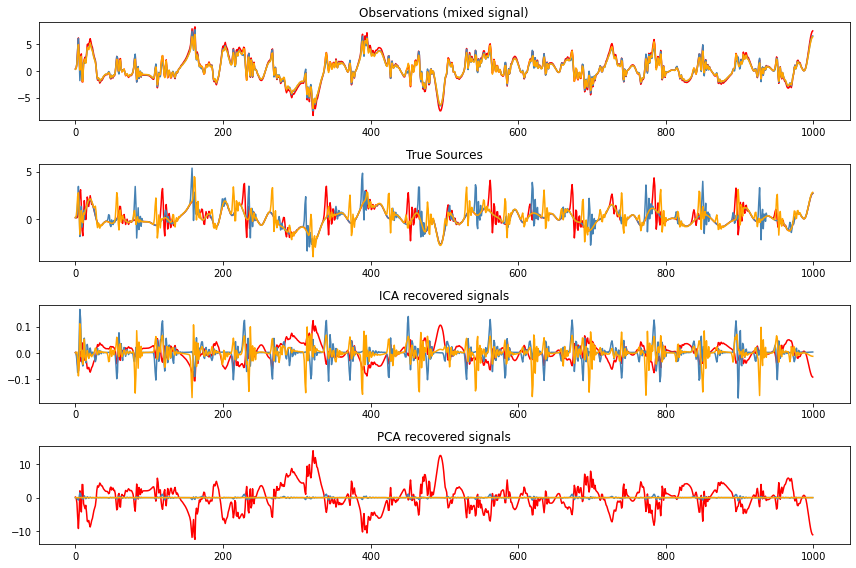

In [10]:
from dsp import bss_ica, bss_pca

# We simulate three people lying in bed, and there are three sensors detecting their SCG signals.
# For each sensor, it receives a combination of three SCG signals, each with a certain time delay
# and attenuation.
s1 = signals[3]
s2 = signals[4]
s3 = signals[5]

time = np.linspace(0, duration, duration * fs)
S = np.c_[s1, s2, s3]
print(S.shape)

S /= S.std(axis=0)  # Standardize data

# Mix data
A = np.array([[0.9, 0.8, 1], [0.5, 0.85, 1.0], [0.9, 0.6, 0.8]])  # Mixing matrix
X = np.dot(S, A.T)  # Generate observations

S_, A_ = bss_ica(X, 3)
H = bss_pca(X, 3)

models = [X, S, S_, H]
names = ['Observations (mixed signal)', 'True Sources', 'ICA recovered signals', 'PCA recovered signals']
colors = ['red', 'steelblue', 'orange']

plt.figure(figsize=(12, 8))
for ii, (model, name) in enumerate(zip(models, names), 1):
    plt.subplot(4, 1, ii)
    plt.title(name)
    for sig, color in zip(model.T, colors):
        plt.plot(sig, color=color)

plt.tight_layout();plt.show()

#### Linear Filter



##### 1. **Butterworth Filter:**
   The Butterworth filter is a popular linear filter designed to pass signals within a specified frequency range while attenuating frequencies outside that range. It is characterized by a smooth frequency response and is commonly used in signal processing and communications. Mathematically, the filter transfer function is given by $H(s) = \frac{1}{1 + (\frac{s}{\omega_c})^{2n}}$, where $s$ is the complex frequency variable, $\omega_c$ is the cutoff frequency, and $n$ is the filter order.

##### 2. **Simple Moving Average (SMA) Filter:**
   The SMA filter is a basic time-domain filter that computes the average of a specified number of consecutive data points. It provides a simple means of smoothing a time series to reveal underlying trends. Mathematically, the SMA for a window size $N$ is given by $y(t) = \frac{1}{N} \sum_{i=1}^{N} x(t-i+1)$.

##### 3. **Exponential Moving Average (EMA) Filter:**
   The EMA filter assigns exponentially decreasing weights to past data points, giving more importance to recent observations. It is widely used for trend analysis and noise reduction. Mathematically, the EMA is defined by $y(t) = \alpha x(t) + (1-\alpha)y(t-1)$, where $\alpha$ is the smoothing factor.

In [6]:
from dsp import butter_highpass_filter, butter_lowpass_filter, butter_bandpass_filter, butter_bandstop_filter, simple_moving_average_filter, exponential_moving_average_filter

from dsp import add_distort_noise, sine_wave

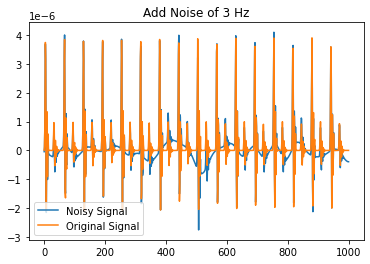

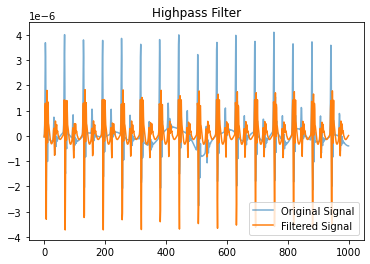

In [7]:
# signal_with_3Hz_Noise, Add noise with a frequency of 3 to the signal. The amplitude of the noise is noise_amplitude * np.std(signal).
signal_with_3Hz_Noise = add_distort_noise(signal, n_samples=1000, sampling_rate=100,noise_frequency=3,  noise_amplitude=0.3, show=True)
filtered_signal_1 = butter_highpass_filter(signal_with_3Hz_Noise, cutoff=3.5, show=True)

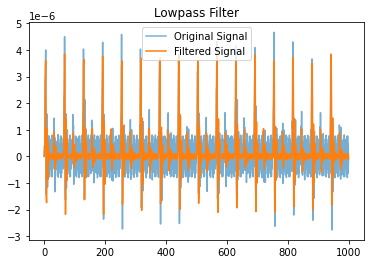

In [8]:
signal_with_45Hz_sine_noise = signal+sine_wave(frequency=45, amplitude=0.8e-6, show=False)
filtered_signal_2 = butter_lowpass_filter(signal_with_45Hz_sine_noise, cutoff=42.5, show=True)

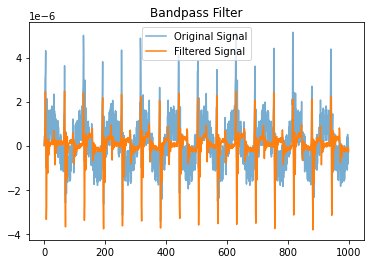

In [9]:
signal_with_1Hz_and_45Hz_sine_noise = signal+sine_wave(frequency=45, amplitude=0.8e-6, show=False)+sine_wave(frequency=1, amplitude=1e-6, show=False)
filtered_signal_3 = butter_bandpass_filter(signal_with_1Hz_and_45Hz_sine_noise, lowcut=1.5, highcut=42.5, show=True)

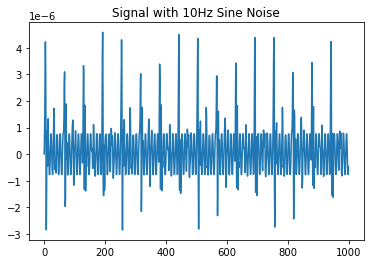

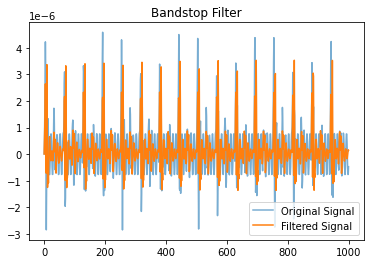

In [10]:
sine_noise = sine_wave(frequency=10, amplitude=0.8e-6, show=False)
signal_with_10Hz_sine_noise = signal + sine_noise
plt.plot(signal_with_10Hz_sine_noise)
plt.title('Signal with 10Hz Sine Noise');plt.show()
filtered_signal_4 = butter_bandstop_filter(signal_with_10Hz_sine_noise, lowcut=9, highcut=11, show=True)

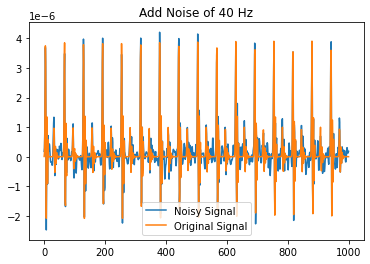

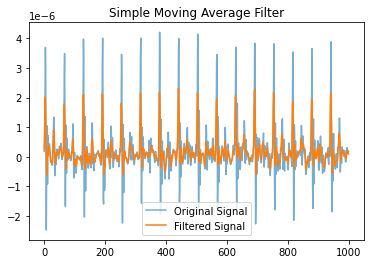

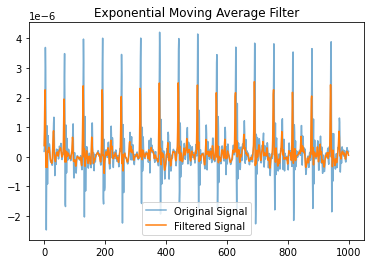

In [11]:
# signal_with_40Hz_Noise, Add noise with a frequency of 40 to the signal. The amplitude of the noise is noise_amplitude * np.std(signal).
signal_with_40Hz_Noise = add_distort_noise(signal, n_samples=1000, sampling_rate=100,noise_frequency=40,  noise_amplitude=0.3, show=True)

filtered_signal_5 = simple_moving_average_filter(signal_with_40Hz_Noise, length=5, show=True)
filtered_signal_6 = exponential_moving_average_filter(signal_with_40Hz_Noise, length=5, show=True)

#### Advanced Filter


##### 1. **Savitzky-Golay Filter (savgol_filter):**
   The Savitzky-Golay filter is a smoothing algorithm that preserves important features of a signal while reducing noise. It employs polynomial fitting within a sliding window to smooth the data. Mathematically, the filter coefficients are determined by least squares fitting, providing a balance between noise reduction and signal preservation.

##### 2. **Wiener Filter:**
   The Wiener filter is an optimal linear filter used for signal deconvolution and noise reduction. It minimizes mean-squared error between the estimated signal and the true signal, enhancing signal-to-noise ratio. Mathematically, the Wiener filter in the frequency domain is given by $H(f) = \frac{S_x(f)}{S_x(f) + S_n(f)}$, where $S_x(f)$ is the signal power spectrum, $S_n(f)$ is the noise power spectrum.

##### 3. **Notch Filter:**
   The notch filter is designed to suppress specific frequencies, often used to eliminate unwanted interference or noise at a particular frequency. It creates a notch or a dip in the frequency response centered around the target frequency. Mathematically, the transfer function of a notch filter can be represented as $H(f) = \frac{1}{1 + \frac{(f/f_0)^2}{Q}}$, where $f_0$ is the center frequency, and $Q$ is the quality factor.

##### 4. **Matched Filter:**
   The matched filter is a signal processing filter that maximizes the signal-to-noise ratio for a known signal when embedded in noise. It is particularly effective in detecting signals with a known template. Mathematically, the matched filter output is the convolution of the received signal and the time-reversed conjugate of the template signal.


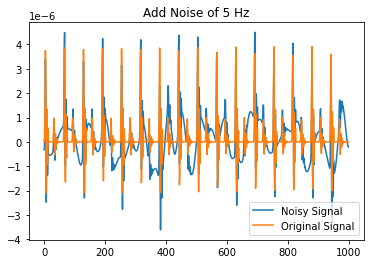

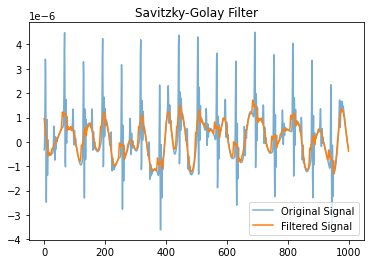

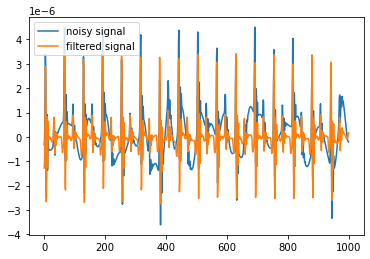

In [12]:
from dsp import savgol_filter, wiener_filter, notch_filter, matched_filter
from dsp import add_distort_noise

# Construct Data for savgol_filter
# it's nice for us to use savgol_filter to get rid of low frequency Noise
# signal_with_5Hz_Noise, Add noise with a frequency of 5 to the signal. The amplitude of the noise is noise_amplitude * np.std(signal).
signal_with_5Hz_noise = add_distort_noise(signal, n_samples=1000, sampling_rate=100,noise_frequency=5,  noise_amplitude=0.8, show=True)

# we can use a savgol filter whose window size is 16 to get the low frequency noise
filtered_signal_7 = savgol_filter(signal_with_5Hz_noise, window_length=16, show=True)

# filtered signal  = noisy signal - output of savgol filter
plt.plot(signal_with_5Hz_noise, label='noisy signal')
plt.plot(signal_with_5Hz_noise - filtered_signal_7, label='filtered signal')
plt.legend()
plt.show()

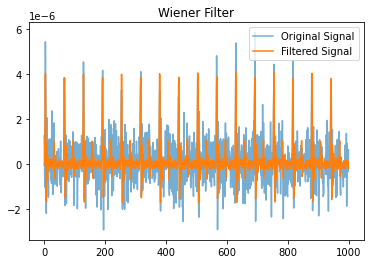

In [13]:
# wiener_filter needs to know the statistical feature of noise
# construct the data for wiener filter
noise_amp = 0.2
noise = np.random.normal(loc=0.0, scale=1.0*noise_amp, size=signal.shape) * np.max(signal)
filtered_signal_8 = wiener_filter(signal + noise, noise, show=True)

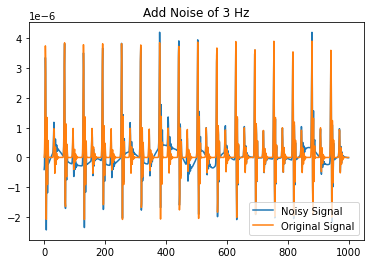

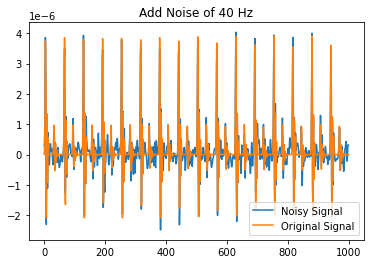

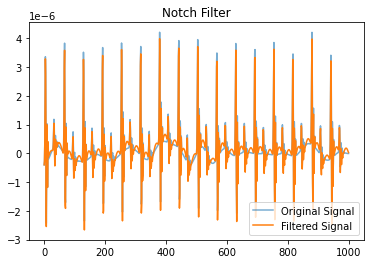

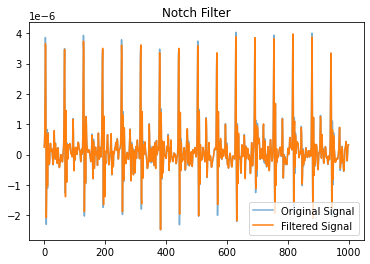

In [14]:
# The notch filter is designed to suppress specific frequencies
# The 'q' parameter controls the width of the notch; higher 'q' values create narrower notches.

signal_with_3Hz_Noise = add_distort_noise(signal, n_samples=1000, sampling_rate=100,noise_frequency=3,  noise_amplitude=0.3, show=True)
signal_with_40Hz_Noise = add_distort_noise(signal, n_samples=1000, sampling_rate=100,noise_frequency=40,  noise_amplitude=0.3, show=True)

filtered_signal_9 = notch_filter(signal_with_3Hz_Noise, cutoff=3, q=8, fs=100, show=True)
filtered_signal_9 = notch_filter(signal_with_40Hz_Noise, cutoff=40, q=5, fs=100, show=True)

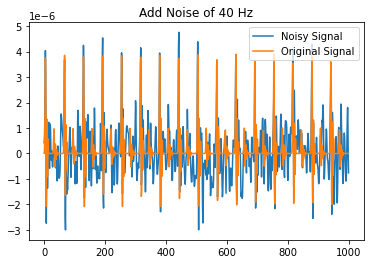

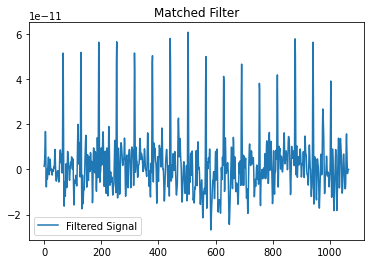

In [15]:
# construct Data for matched filter
# the amplitude of 40Hh noise is very large
signal_with_40Hz_Noise_ = add_distort_noise(signal, n_samples=1000, sampling_rate=100,noise_frequency=40, noise_amplitude=1, show=True)
template = signal[:67]
filtered_signal_10 = matched_filter(signal_with_40Hz_Noise_, template, show=True)

#### FFT, Wavelet Denoising

##### 1. **Wavelet Denoising:**
   Wavelet denoising is a technique that utilizes wavelet transforms to remove noise from signals or images. It decomposes the signal into different frequency components, thresholds the coefficients, and reconstructs the signal, effectively reducing noise. Mathematically, the denoised signal $y(t)$ is obtained by thresholding wavelet coefficients $W_j$ at a certain level: $y(t) = \sum_{j} \text{Threshold}(W_j)$.

##### 2. **FFT Denoise:**
   FFT denoising employs the Fast Fourier Transform (FFT) to analyze and filter out unwanted frequency components from a signal. By transforming the signal into the frequency domain, one can selectively remove or attenuate specific frequency bands associated with noise. Mathematically, denoising is achieved by zeroing or attenuating certain frequency components in the Fourier-transformed signal, followed by an inverse FFT to obtain the denoised signal.

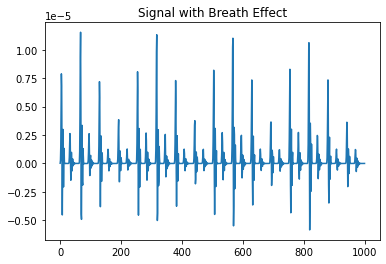

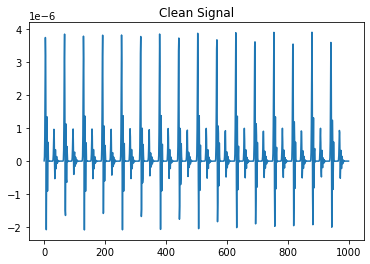

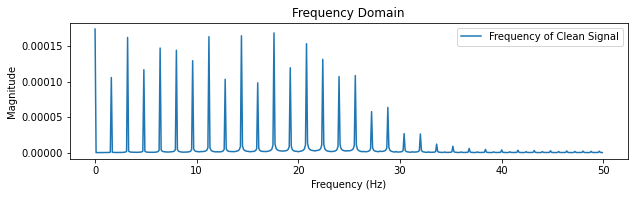

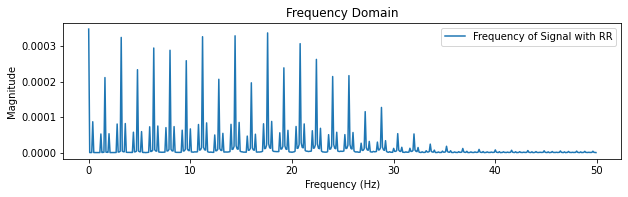

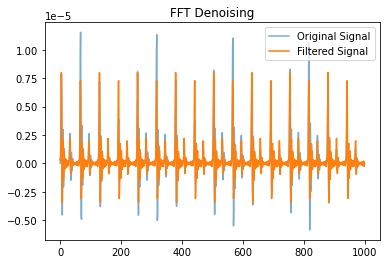

In [95]:
from dsp import fft_denoise, wavelet_denoise

# Construct Data for fft denoising
# use sin wave to simulate the breath effect

fs = 100
t = np.linspace(0, 10, fs * 10)
omega = 0.4
rr = np.sin(2 * np.pi * omega * t) + 2
signal_RR = signal * rr

plt.plot(signal_RR);plt.title('Signal with Breath Effect');plt.show()
plt.plot(signal);plt.title('Clean Signal');plt.show()

# Let's look at the difference in frequency domain

plt.figure(figsize=(10, 2.5))
fft_result_clean = np.fft.fft(signal)
fft_freq_clean = np.fft.fftfreq(len(signal), 1/fs)
spectrum_clean = np.abs(fft_result_clean)
plt.plot(fft_freq_clean[:len(fft_freq_clean) // 2], spectrum_clean[:len(fft_result_clean) // 2], label='Frequency of Clean Signal')
plt.title('Frequency Domain');plt.xlabel('Frequency (Hz)');plt.ylabel('Magnitude');plt.legend();plt.show()

plt.figure(figsize=(10, 2.5))
fft_result = np.fft.fft(signal_RR)
fft_freq = np.fft.fftfreq(len(signal_RR), 1/fs)
spectrum = np.abs(fft_result)
plt.plot(fft_freq[:len(fft_freq) // 2], spectrum[:len(fft_freq) // 2], label='Frequency of Signal with RR')
plt.title('Frequency Domain');plt.xlabel('Frequency (Hz)');plt.ylabel('Magnitude');plt.legend();plt.show()

# use fft to denoise
filtered_signal_12 = fft_denoise(signal_RR, threshold = 0.5e-5 ** 2, show=True)

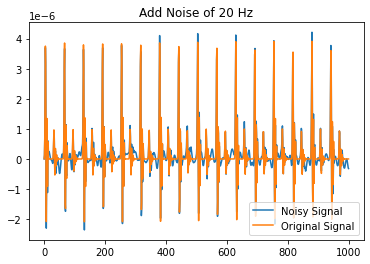

maximum level is 5


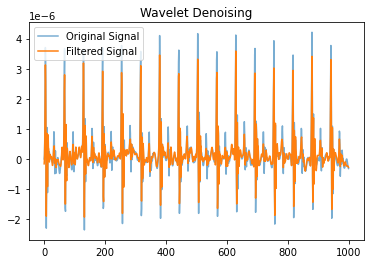

In [103]:
signal_with_3Hz_Noise = add_distort_noise(signal, n_samples=1000, sampling_rate=100, noise_frequency=20,  noise_amplitude=0.2, show=True)
filtered_signal_13 = wavelet_denoise(signal_with_3Hz_Noise, 'db12',  0.1, show=True)

##### Adaptive Filter

The adaptive filter is a type of digital filter that adjusts its parameters based on the input data it receives. In simpler terms, it's a filter that can change its behavior to better match the characteristics of the signals it processes.

Mathematically, an adaptive filter often involves adjusting a set of coefficients. The general form of an adaptive filter output $y$ based on an input signal $x$ and a set of adaptive coefficients $w$ is given by:

$$ y[n] = \sum_{k=0}^{M-1} w[k] \cdot x[n-k] $$

Here,
- $y[n]$ is the output signal at time $n$,
- $x[n-k]$ represents the input signal delayed by $k$ samples,
- $w[k]$ is the adaptive coefficient associated with the $k$-th delayed input, and
- $M$ is the number of coefficients in the filter.

The key idea is that during operation, the filter adjusts its coefficients $ w[k] $ based on the difference between its output and some desired signal. This adaptation is typically achieved using algorithms like the Least Mean Squares (LMS) or Recursive Least Squares (RLS).

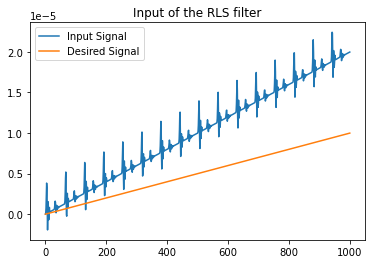

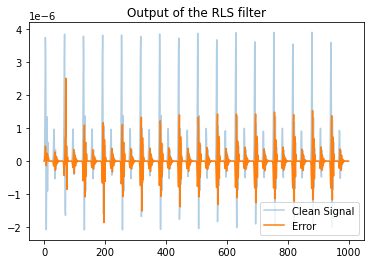

In [32]:
from dsp import rls_filter, lms_filter

# x = clean signal + noise
# Assuming the noise here is linear.
linear_noise = np.linspace(0, 10, 1000, endpoint=False) * 2 * 1e-6
x = signal + linear_noise

# desired signal is also set to be linear
# but desired signal d is not equal to linear noise
# Making the input signal x approximate desired signal d  means approximating the portions in d that have high correlation with the input signal.
d = np.linspace(0, 10, 1000, endpoint=False) * 1e-6
plt.title('Input of the RLS filter')
plt.plot(x, label='Input Signal');plt.plot(d, label='Desired Signal');plt.legend();plt.show()
y, e, w = rls_filter(x, d, n=1, mu=0.1, show=False)
plt.title('Output of the RLS filter')
plt.plot(signal, alpha=0.35, label='Clean Signal');plt.plot(e, label='Error');plt.legend();plt.show()

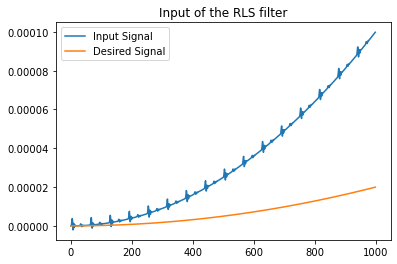

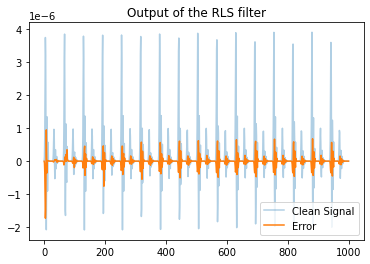

In [43]:
# Polynomial functions are also acceptable.
x = signal + np.linspace(0, 10, 1000, endpoint=False) ** 2 * 1e-6
d = np.linspace(0, 10, 1000, endpoint=False) ** 2 * 0.2 * 1e-6

plt.title('Input of the RLS filter')
plt.plot(x, label='Input Signal');plt.plot(d, label='Desired Signal');plt.legend();plt.show()
y, e, w = rls_filter(x, d, n=1, mu=0.1, show=False)
plt.title('Output of the RLS filter')
plt.plot(signal, alpha=0.35, label='Clean Signal');plt.plot(e, label='Error');plt.legend();plt.show()

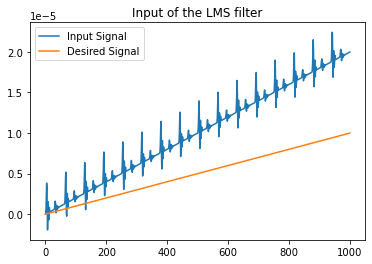

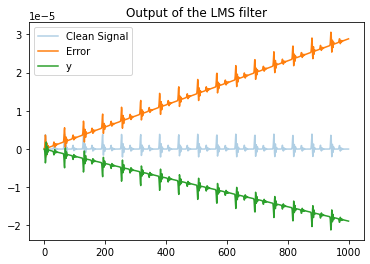

In [45]:
from dsp import lms_filter

# x = clean signal + noise
# Assuming the noise here is linear.
linear_noise = np.linspace(0, 10, 1000, endpoint=False) * 2 * 1e-6
x = signal + linear_noise

# desired signal is also set to be linear
# but desired signal d is not equal to linear noise
d = np.linspace(0, 10, 1000, endpoint=False) * 1e-6
plt.title('Input of the LMS filter')
plt.plot(x, label='Input Signal');plt.plot(d, label='Desired Signal');plt.legend();plt.show()
y, e, w = lms_filter(x, d, n=1, mu=0.1, show=False)
plt.title('Output of the LMS filter')
plt.plot(signal, alpha=0.35, label='Clean Signal');plt.plot(e, label='Error');plt.plot(y, label='y');plt.legend();plt.show()

#### Averaging by Dynamic Time Warping

Dynamic Time Warping (DTW) is a similarity measure between two temporal sequences, accommodating variations in their alignment and speed. It finds an optimal warping path by minimizing the accumulated distance between corresponding points. Mathematically, given sequences $ A = [a_1, a_2, ..., a_n]$ and $B = [b_1, b_2, ..., b_m]$, DTW constructs a cost matrix $C$ where $C(i, j)$ represents the local distance between $a_i$ and $b_j$.  It then calculates an optimal path from $C(1, 1)$ to $ C(n, m)$ through dynamic programming. DTW is widely used in pattern recognition, speech processing, and signal analysis for aligning time series data.

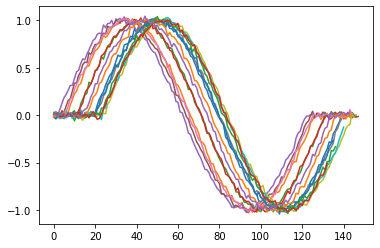

In [8]:
from dsp import performSOFTDBA, performDBA, performICDTW, performNLAAF1, performNLAAF2


#generating synthetic data
n_series = 15
length = 150

series = list()
padding_length=30
indices = range(0, length-padding_length)
main_profile_gen = np.array([np.sin(2*np.pi*j/len(indices)) for j in indices])
randomizer = lambda j:np.random.normal(j,0.02)
randomizer_fun = np.vectorize(randomizer)
for i in range(0,n_series):
    n_pad_left = np.random.randint(0,padding_length)
    #adding zero at the start or at the end to shif the profile
    series_i = np.pad(main_profile_gen,(n_pad_left,padding_length-n_pad_left),mode='constant',constant_values=0)
    #chop some of the end to prove it can work with multiple lengths
    l = np.random.randint(length-20,length+1)
    series_i = series_i[:l]
    #randomize a bit
    series_i = randomizer_fun(series_i)

    series.append(series_i)
series = np.array(series)

#plotting the synthetic data
for s in series:
    plt.plot(range(0,len(s)), s)
plt.show()

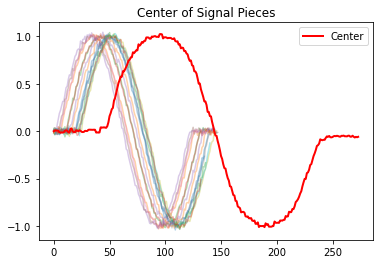

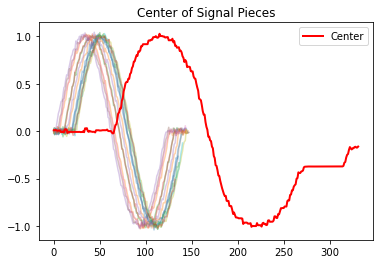

In [13]:
# the feature of NLAAF: the length of center cannot be controlled
# if we want to get the center of 2 time series A (N points) and B (M points) by NLAAF
# the length of center is in the range of [max(N, M), N + M - 1]

average_series_NLAAF1 = performNLAAF1(list(series), show=True)
average_series_NLAAF2 = performNLAAF2(list(series), show=True)

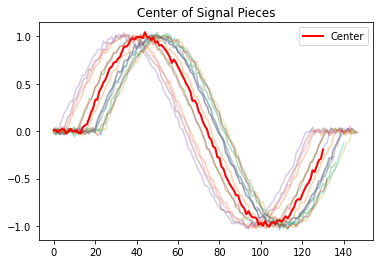

In [12]:
# ICDTW is an iterative approach for time series averaging
# with ICDTW we can control the length of center
average_series_ICDTW = performICDTW(list(series), show=True)

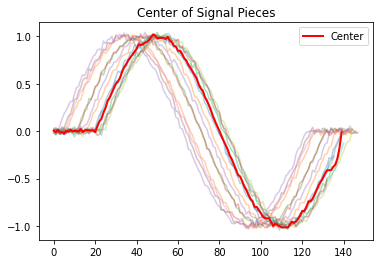

In [10]:
# DBA is a baseline!
# the length of center can also be controlled
# an iterative approach
average_series_DBA = performDBA(series, show=True)

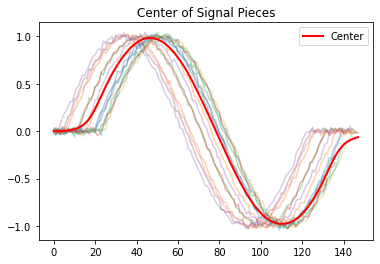

In [11]:
# convert an un-convex problem into an convex optimization
average_series_SoftDBA = performSOFTDBA(series, show=True)